# GIS routing

All the algorithms presented so far are almost what you are going to need if you want to create your routing system and the big names in the field like Google and Apple and Microsoft are using modified versions of these algorithms because they have a lot of data and huge infrastructure so they could tune their heuristic to give impressive preformance.  


There is a highly-cited survey on all of these methods and more and how they are used in the industry at [Route Planning in Transportation Networks](https://arxiv.org/pdf/1504.05140.pdf). The authors of that survey are pretty much the creators of that field and most of these algorithms, so stalking them will really help you in this course.

---

We decided to make this notebook to only show you animation of the algorithms and the trend of expansion for each one. We didn't provide the animation in the algorithms notebooks because we didn't want to smear the code with animations utilities and here you can scroll up and down and see the difference in the same notebook and we would also use a bigger map.

# Getting the map

In [1]:
import osmnx as ox
from IPython.display import IFrame, HTML
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from operator import attrgetter
from tqdm import tqdm
import numpy as np
import time
from collections import deque
import networkx as nx
from utilities import *

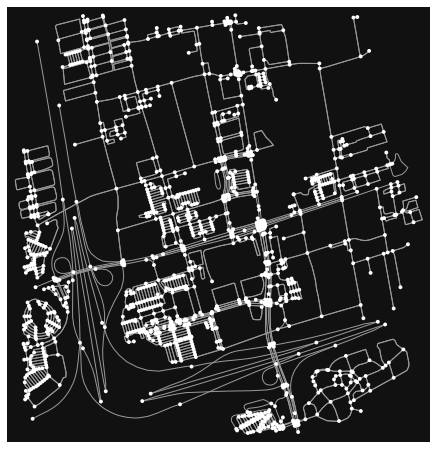

In [2]:
G = ox.graph_from_address('vaughan', dist= 1400)
fig, ax = ox.plot_graph(G)

In [3]:
len(G)

1330

In [4]:
G.nodes()

NodeView((29658954, 29659054, 29659056, 29659153, 29659163, 29659166, 29659214, 29659217, 29659230, 29659234, 29659256, 29659282, 29659284, 29659285, 29659299, 29659309, 29659317, 29659320, 29659337, 29659361, 29659378, 29659389, 29659391, 29659398, 34290892, 250224519, 250225278, 382741474, 391889553, 391892572, 391899764, 391900092, 391902031, 391905424, 391906329, 391910220, 391910564, 391911863, 391912003, 391912538, 391914281, 391915408, 391917373, 391919295, 392154169, 392184029, 392184031, 392350739, 392350940, 392350943, 392350956, 392350957, 392351033, 392351036, 392351041, 392351042, 392351051, 392351055, 392351059, 392351060, 392351061, 392351062, 392351108, 392351130, 392351138, 392351142, 392351167, 392351231, 392351236, 392351237, 392351248, 392351442, 392351448, 392351595, 392351616, 392351619, 392351639, 392351640, 392351642, 392351647, 410940985, 701446406, 701446424, 701446428, 701446429, 701446442, 701446446, 701446447, 701446455, 701446463, 701446470, 701446479, 701

let's find two arbitrary vertices to be our source and destination

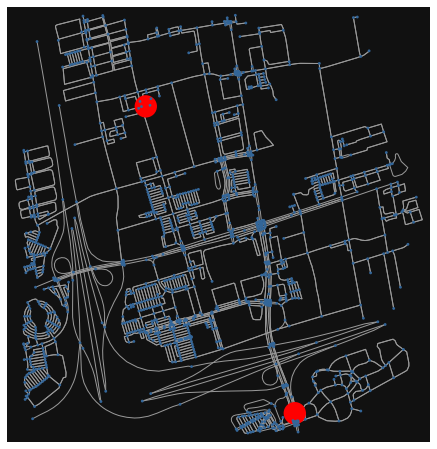

In [5]:
highlighted = [29658954, 7450058649]

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [500 if node in highlighted else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

Let's make our usual set up

In [6]:
origin = Node(graph = G, osmid = 29658954)
destination = Node(graph = G, osmid = 7450058649)

### Breadth First Search
please note `colors` array which serves as stamp for the current state of the traversing and expansion of the nodes, otherwise it is the same algorithm.

In [15]:
%%time
bar = tqdm(total=len(G))
colors = []

route = []
frontier = deque([origin])
explored = set()

found = False

while frontier and not found:
    bar.update(1); time.sleep(0.05) # for the progress bar -- ignore
    node = frontier.popleft()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route = child.path()
                found = True
                
                state_color = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([state_color]*50)]]) # all that packing/unpacking to extend the period
                                                        # in the video 
                
            frontier.append(child)

    state_color = [1 if node in explored else 6 for node in G.nodes()]
    colors.append(state_color)
    
bar.close()
print("The route is \n\n",route, "\n\nits cost is\n\n", cost(G, route))

 69%|██████▉   | 916/1330 [00:48<00:21, 18.85it/s]

The route is 

 [29658954, 701446580, 701446835, 391892572, 2808642993, 2808642992, 3918922979, 7241520823, 5298057161, 701447100, 382741474, 701446646, 4933260585, 701446801, 4931701390, 701446500, 701446614, 4359477382, 701446929, 701446958, 4359471925, 7143191824, 34290892, 4555563325, 701446536, 7226985204, 7226985205, 7226985208, 7321414078, 7450058643, 7450058649] 

its cost is

 3440.0470000000005
CPU times: user 3.14 s, sys: 257 ms, total: 3.39 s
Wall time: 48.6 s


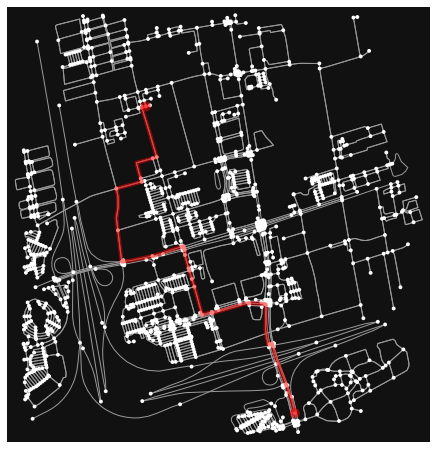

In [17]:
fig, ax = ox.plot_graph_route(G, route)

Focus on how breadth first search traverse on the graph and how it expands on all directions and waste time

In [18]:
%%capture
ani = animate_simple(G, np.array(colors))

In [19]:
# this would take some time (2-3 mins) to be rendered
HTML(ani.to_html5_video())

### Depth First Search

In [ ]:
route = []
bar = tqdm(total=len(G))
colors = []
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.pop()
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                colornow = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([colornow]*50)]])   # to make the route node colored for a long time
                found = True
                continue
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)
bar.close()
print(route)

In [ ]:
fig, ax = ox.plot_graph_route(G, route)

What can we learn from the below animation and `tqdm` progress bar about DFS?  

BFS my be wasting its time expanding hopeless nodes but it changes its mind quickly, DFS do the same thing but there is insistence to finish a certain road till the end and then backtrack.  

DFS is only good for its memory consumption.

In [ ]:
%%capture
ani = animate_simple(G, np.array(colors))

In [ ]:
HTML(ani.to_html5_video())

### A* search

In [ ]:
toGoal, toDestination = Astar_distance(G, 6655397492, 2493811210)

In [ ]:
frontier = PriorityQueue('min', lambda node: toGoal[node.osmid] + toDestination[node.osmid])
colors = []
route = []
bar = tqdm(total=len(G))

frontier.append(origin)
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.pop()
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        colornow = [1 if node in route else 6 for node in G.nodes()]
        colors.extend([*[*([colornow]*50)]])   
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                colornow = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([colornow]*50)]])   
                found = True
                continue
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)
bar.close()
print(route)

In [ ]:
fig, ax = ox.plot_graph_route(G, route)

A* is the best algorithm in the traditional search methods and used in a lot of routing and navigation system, why?  
Its heuristic is very useful in directing the search and the traversing as it has _eyes_ on __both__ the origin and destination.

In [ ]:
%%capture
ani = animate_simple(G, np.array(colors))

In [ ]:
HTML(ani.to_html5_video())

### Dijkstra Algorithm

In [ ]:
route = []
bar = tqdm(total=len(G))
colors = []
frontier = [origin]
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    # This is the closest node to the origin .. this is pretty much Dijkstra algorithm idea
    node = min(frontier, key = attrgetter('from_origin'))
    frontier.remove(node)
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        colornow = [1 if node in route else 6 for node in G.nodes()]
        colors.extend([*[*([colornow]*50)]])   
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                colornow = [1 if node in route else 6 for node in G.nodes()]
                colors.extend([*[*([colornow]*50)]])   
                found = True
                continue
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)
bar.close()
print(route)

In [ ]:
fig, ax = ox.plot_graph_route(G, route)

Maybe dijkstra is not the fastest or the _smartest_ algorithm, but it is the only algorithm that gives us THE shortest path on a graph.

Please note that

In [ ]:
%%capture
ani = animate_simple(G, np.array(colors))

In [ ]:
HTML(ani.to_html5_video())